# Soft Policy iteration

In [ ]:
# Q-values et policy stochastique
env = gym.make("Taxi-v3")
env = env.unwrapped
nS = env.observation_space.n
nA = env.action_space.n
Q = np.zeros((nS, nA))
policy = np.ones((nS, nA)) / nA  # policy uniforme au départ

gamma = 0.95

In [ ]:
nS, nA

In [ ]:
def soft_policy_evaluation(Q, policy, gamma, n_iter=100):
    for _ in range(n_iter):
        Q_new = np.zeros_like(Q)
        for s in range(nS):
            for a in range(nA):
                q_sa = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    # valeur augmentée avec entropie de la policy next_state
                    v_next = np.sum(policy[next_state] * (Q[next_state] -np.log(policy[next_state]+1e-8)))
                    q_sa += prob * (reward + gamma * v_next)
                Q_new[s, a] = q_sa
        Q[:] = Q_new
    return Q


In [ ]:
def soft_policy_improvement(Q):
    """
    Projection KL : π_new(a|s) ∝ exp(Q(s,a)/α)
    avec stabilisation numérique.
    """
    Q_stable = Q - np.max(Q, axis=1, keepdims=True)  # stabilisation
    exp_Q = np.exp(Q_stable)
    policy_new = exp_Q / np.sum(exp_Q, axis=1, keepdims=True)
    return policy_new


In [ ]:
def soft_policy_evaluation(Q, policy, gamma, n_iter=100):
    for _ in range(n_iter):
        Q_new = np.zeros_like(Q)
        for s in range(nS):
            for a in range(nA):
                q_sa = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    # valeur augmentée avec entropie de la policy next_state
                    v_next = np.sum(policy[next_state] * (Q[next_state] -np.log(policy[next_state]+1e-8)))
                    q_sa += prob * (reward + gamma * v_next)
                Q_new[s, a] = q_sa
        Q[:] = Q_new
    return Q


In [ ]:
def soft_policy_improvement(Q):
    """
    Projection KL : π_new(a|s) ∝ exp(Q(s,a)/α)
    avec stabilisation numérique.
    """
    Q_stable = Q - np.max(Q, axis=1, keepdims=True)  # stabilisation
    exp_Q = np.exp(Q_stable)
    policy_new = exp_Q / np.sum(exp_Q, axis=1, keepdims=True)
    return policy_new


In [ ]:
n_iterations = 10
for i in range(n_iterations):
    print("iteration ",i)
    Q = soft_policy_evaluation(Q, policy, gamma)
    policy = soft_policy_improvement(Q)

In [ ]:
state, _ = env.reset()
done = False
total_reward = 0

while not done:
    action = np.random.choice(nA, p=policy[state])
    state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    done = terminated or truncated

print("Total reward:", total_reward)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import gymnasium as gym
import numpy as np

plt.rcParams["animation.html"] = "jshtml"

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=True, interval=300):
    fig = plt.figure(figsize=(5, 5))
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
        blit=True
    )
    plt.close(fig)
    return anim

def show_one_episode(policy, seed=42):
    """
    Animation d'un épisode FrozenLake avec une policy tabulaire stochastique
    (Soft Policy Iteration).
    """
    env = gym.make(
        "Taxi-v3",
        render_mode="rgb_array"
    )

    np.random.seed(seed)
    state, _ = env.reset(seed=seed)
    frames = []
    total_reward = 0
    done = False

    while not done:
        frames.append(env.render())
        action = np.random.choice(env.action_space.n, p=policy[state])
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    env.close()
    print(f"Total reward for this episode: {total_reward}")
    return HTML(plot_animation(frames).to_jshtml())

# Appel
show_one_episode(policy)


# Comparaison between SAC, DDPG and PPO

Training PPO
Training DDPG | seed=0
Training DDPG | seed=1
Training DDPG | seed=2
Training SAC | seed=0
Training SAC | seed=1
Training SAC | seed=2


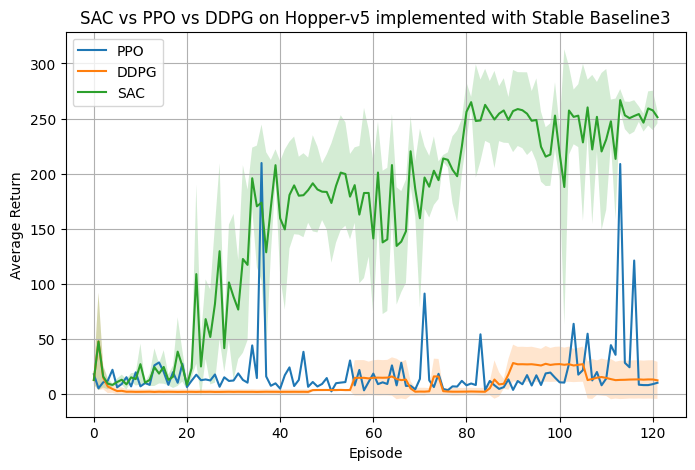

In [45]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC, DDPG, PPO
from stable_baselines3.common.monitor import Monitor

# ----------------------------
# Paramètres
# ----------------------------
ENV_ID = "Hopper-v5"
TIMESTEPS = 10_000
SEEDS = [0, 1, 2]
ALGOS = ["PPO", "DDPG", "SAC"]

# ----------------------------
# Entraînement + collecte rewards
# ----------------------------
def train(algo_name, seed=0):
    env = Monitor(gym.make(ENV_ID))
    
    if algo_name == "SAC":
        model = SAC("MlpPolicy", env, verbose=0, seed=seed)
    elif algo_name == "DDPG":
        model = DDPG("MlpPolicy", env, verbose=0, seed=seed)
    elif algo_name == "PPO":
        model = PPO("MlpPolicy", env, verbose=0)

    model.learn(total_timesteps=TIMESTEPS)

    # rewards par épisode (directement depuis Monitor)
    rewards = env.get_episode_rewards()
    env.close()
    return rewards

# ----------------------------
# Lancement
# ----------------------------
results = {algo: [] for algo in ALGOS}

for algo in ALGOS:
    if algo=="PPO":
        print(f"Training {algo}")
        rewards = train(algo)
        results[algo].append(rewards)
    else:
        for seed in SEEDS:
            print(f"Training {algo} | seed={seed}")
            rewards = train(algo, seed)
            results[algo].append(rewards)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(8, 5))
min_len = min(len(r) for r in results[algo] for algo in ALGOS)
for algo in ALGOS:
    data = np.array([r[:min_len] for r in results[algo]])
    mean = data.mean(axis=0)
    std = data.std(axis=0)

    plt.plot(mean, label=algo)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.title(f"SAC vs PPO vs DDPG on {ENV_ID} implemented with Stable Baseline3")
plt.legend()
plt.grid()
plt.show()